## EN 520.665 Machine Perception Project 1
#### Yu-Chun(Arthur) Ku, Ching-Yang(Austin) Huang
##### yck4@jh.edu, chuan120@jh.edu

### AlexNet model fgsm attack and defense

In [1]:
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import argparse

from AlexNet import AlexNet
from misc import progress_bar

In [2]:
def fgsm_attack(input, epsilon, data_grad):
    pert_out = input + epsilon*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

In [3]:
def attack_test(model,device,test_loader,epsilon,attack):
    correct = 0
    total = 0
    examples = []
    adv_examples = []
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        criterion = nn.CrossEntropyLoss().to(device)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data,epsilon,data_grad)

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        
        if final_pred.item() == target.item():
            correct += 1
            
        ex = data.squeeze().detach().cpu().numpy()
        examples.append( (init_pred.item(), final_pred.item(), ex) )
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, examples, adv_examples

In [4]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

Files already downloaded and verified


Here we chose epsilons as 0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, and 0.3 since the accuracy dramatically dropped between 0 to 0.05. And after 0.05, the accuracy flattened. We chose several epsilon values, such as 0.1, 0.2, and 0.3, to show our observation and conclusion.

Epsilon: 0	Test Accuracy = 7332 / 10000 = 0.7332
Epsilon: 0.007	Test Accuracy = 2884 / 10000 = 0.2884
Epsilon: 0.01	Test Accuracy = 2160 / 10000 = 0.216
Epsilon: 0.02	Test Accuracy = 1107 / 10000 = 0.1107
Epsilon: 0.03	Test Accuracy = 828 / 10000 = 0.0828
Epsilon: 0.05	Test Accuracy = 692 / 10000 = 0.0692
Epsilon: 0.1	Test Accuracy = 720 / 10000 = 0.072
Epsilon: 0.2	Test Accuracy = 842 / 10000 = 0.0842
Epsilon: 0.3	Test Accuracy = 935 / 10000 = 0.0935


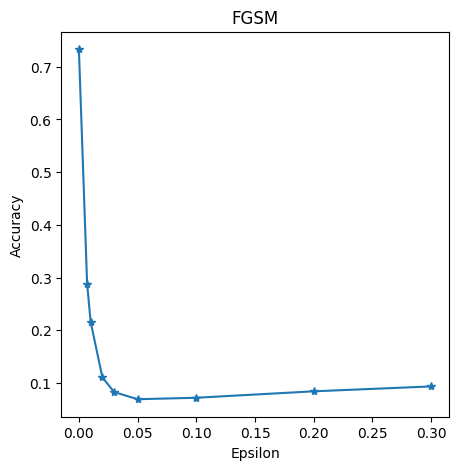

In [5]:
epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
accuracies = []
examples = []
adv_examples = []
device = torch.device("mps")
model = torch.load('./model.pth')

for i in range(len(epsilons)):
    acc, ex, adv_ex = attack_test(model, device, test_loader, epsilons[i], "fgsm")
    accuracies.append(acc)
    
    if not examples:
        examples.append(ex)
        
    adv_examples.append([])
    adv_examples[i].append(adv_ex)
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.title("FGSM")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [6]:
def run_train():
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100, shuffle=True)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=100, shuffle=False)
    
    device = torch.device("mps")
    model = torch.load('./model.pth')
    
    for data in train_loader:
        input, label  = data[0].to(device),data[1].to(device)
        softlabel  = F.log_softmax(model(input),dim=1)
        data[1] = softlabel
    
    modelG = AlexNet().to(device)
    optimizer = optim.Adam(modelG.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
    criterion = nn.CrossEntropyLoss().to(device)
    epochs = 100
    
    accuracy = 0
    
    # Train
    def train(model, modelG, device, train_loader, optimizer, criterion):
        modelG.train()
        train_loss = 0
        train_correct = 0
        total = 0

        for batch_num, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = modelG(data)
            output = F.log_softmax(output/100,dim=1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            prediction = torch.max(output, 1)  # second param "1" represents the dimension to be reduced
            total += target.size(0)

            # train_correct incremented by one if predicted right
            train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

            progress_bar(batch_num, len(train_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                         % (train_loss / (batch_num + 1), 100. * train_correct / total, train_correct, total))

        return train_loss, train_correct / total
    # Train End
    
    for epoch in range(1, epochs + 1):
        print("\n===> epoch: %d/100" % epoch)
        train_result = train(model, modelG, device, train_loader, optimizer, criterion)
        print(train_result)
        scheduler.step()

    # Test
    def test(modelG, device, test_loader, criterion):
        print("test:")
        modelG.eval()
        test_loss = 0
        test_correct = 0
        total = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = modelG(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                prediction = torch.max(output, 1)
                total += target.size(0)
                test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())

                progress_bar(batch_num, len(test_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                             % (test_loss / (batch_num + 1), 100. * test_correct / total, test_correct, total))

        return test_loss, test_correct / total
    # Test End
    
    test_result = test(modelG, device, test_loader, criterion)
    accuracy = max(accuracy, test_result[1])
    print("===> BEST ACC. PERFORMANCE: %.3f%%" % (accuracy * 100))
    
    # Save
    def save(modelG):
        model_out_path = "FGSM_Alex.pth"
        torch.save(modelG, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))
        
    save(modelG)

In [7]:
def defense(test_loader):
    run_train()
    
    epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
    accuracies = []
    examples = []
    adv_examples = []
    device = torch.device("mps")
    modelF = torch.load('./FGSM_Alex.pth')
    
    # model = AlexNet().to(device)
    # model.load_state_dict(modelF.state_dict())
    for i in range(len(epsilons)):
        acc, ex, adv_ex = attack_test(modelF, device, test_loader, epsilons[i], "fgsm")
        accuracies.append(acc)

        if not examples:
            examples.append(ex)

        adv_examples.append([])
        adv_examples[i].append(adv_ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title("FGSM")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

Files already downloaded and verified
Files already downloaded and verified

===> epoch: 1/100
 500/500 [================================================================================>]  Step: 62ms | Tot: 31s982ms | Loss: 1.8608 | Acc: 26.028% (13014/50000)..........................................................................]  Step: 68ms | Tot: 692ms | Loss: 2.3024 | Acc: 10.636% (117/1100) [========================================>.......................................]  Step: 68ms | Tot: 16s226ms | Loss: 2.0180 | Acc: 19.502% (4934/25300)
(930.377548456192, 0.26028)

===> epoch: 2/100
 500/500 [================================================================================>]  Step: 62ms | Tot: 31s686ms | Loss: 1.4508 | Acc: 44.892% (22446/50000)
(725.4114636182785, 0.44892)

===> epoch: 3/100
 500/500 [================================================================================>]  Step: 63ms | Tot: 31s804ms | Loss: 1.2022 | Acc: 56.240% (28120/50000)
(601.0961608886719, 

 500/500 [================================================================================>]  Step: 65ms | Tot: 32s489ms | Loss: 0.6314 | Acc: 78.104% (39052/50000)========>....................................................................]  Step: 66ms | Tot: 4s769ms | Loss: 0.6214 | Acc: 78.635% (5819/7400) [===============>................................................................]  Step: 66ms | Tot: 6s325ms | Loss: 0.6240 | Acc: 78.602% (7703/9800) [================================================>...............................]  Step: 65ms | Tot: 19s550ms | Loss: 0.6286 | Acc: 78.260% (23478/30000)
(315.71413001418114, 0.78104)

===> epoch: 12/100
 500/500 [================================================================================>]  Step: 65ms | Tot: 32s826ms | Loss: 0.5991 | Acc: 79.422% (39711/50000)========================>.......................................................]  Step: 71ms | Tot: 10s43ms | Loss: 0.5994 | Acc: 79.252% (12284/15500) [=============

 500/500 [================================================================================>]  Step: 65ms | Tot: 33s308ms | Loss: 0.5318 | Acc: 81.490% (40745/50000)=====================>..........................................................]  Step: 67ms | Tot: 9s165ms | Loss: 0.5263 | Acc: 81.770% (11039/13500) [========================>.......................................................]  Step: 67ms | Tot: 10s190ms | Loss: 0.5303 | Acc: 81.687% (12253/15000) [=========================>......................................................]  Step: 66ms | Tot: 11s12ms | Loss: 0.5338 | Acc: 81.599% (13219/16200) [==========================>.....................................................]  Step: 67ms | Tot: 11s80ms | Loss: 0.5330 | Acc: 81.620% (13304/16300) [==========================>.....................................................]  Step: 67ms | Tot: 11s349ms | Loss: 0.5344 | Acc: 81.569% (13622/16700) [============================>...................................

 500/500 [================================================================================>]  Step: 62ms | Tot: 32s170ms | Loss: 0.3137 | Acc: 89.148% (44574/50000).....................................................................]  Step: 66ms | Tot: 66ms | Loss: 0.2405 | Acc: 91.000% (182/200) [=>..............................................................................]  Step: 66ms | Tot: 598ms | Loss: 0.3017 | Acc: 89.500% (895/1000) [==>.............................................................................]  Step: 66ms | Tot: 799ms | Loss: 0.2950 | Acc: 89.615% (1165/1300) [=====================================>..........................................]  Step: 70ms | Tot: 15s144ms | Loss: 0.3050 | Acc: 89.453% (20753/23200)
(156.85286709666252, 0.89148)

===> epoch: 25/100
 500/500 [================================================================================>]  Step: 65ms | Tot: 32s535ms | Loss: 0.3067 | Acc: 89.298% (44649/50000)=======================>.........

 500/500 [================================================================================>]  Step: 65ms | Tot: 31s972ms | Loss: 0.2397 | Acc: 91.568% (45784/50000)==================>.............................................................]  Step: 67ms | Tot: 7s405ms | Loss: 0.2224 | Acc: 92.293% (10706/11600) [==================>.............................................................]  Step: 67ms | Tot: 7s539ms | Loss: 0.2232 | Acc: 92.237% (10884/11800) [===================>............................................................]  Step: 66ms | Tot: 7s807ms | Loss: 0.2246 | Acc: 92.164% (11244/12200) [==================================================================>.............]  Step: 65ms | Tot: 26s724ms | Loss: 0.2343 | Acc: 91.825% (38383/41800)
(119.86419712752104, 0.91568)

===> epoch: 31/100
 500/500 [================================================================================>]  Step: 64ms | Tot: 32s53ms | Loss: 0.2358 | Acc: 91.976% (45988/50000)=======

 500/500 [================================================================================>]  Step: 65ms | Tot: 4m30s | Loss: 0.1752 | Acc: 93.900% (46950/50000)0)00)...........................................................................]  Step: 67ms | Tot: 1s691ms | Loss: 0.1584 | Acc: 94.407% (2549/2700) [===============================>................................................]  Step: 66ms | Tot: 20s318ms | Loss: 0.1529 | Acc: 94.607% (18543/19600) [================================>...............................................]  Step: 70ms | Tot: 20s716ms | Loss: 0.1540 | Acc: 94.554% (19100/20200) [================================>...............................................]  Step: 65ms | Tot: 20s848ms | Loss: 0.1538 | Acc: 94.564% (19291/20400) [=========================================>......................................]  Step: 67ms | Tot: 24s483ms | Loss: 0.1639 | Acc: 94.290% (24421/25900) [=========================================>.........................

 500/500 [================================================================================>]  Step: 69ms | Tot: 32s169ms | Loss: 0.1295 | Acc: 95.596% (47798/50000)[===========================>....................................................]  Step: 63ms | Tot: 10s905ms | Loss: 0.1111 | Acc: 96.178% (16254/16900) [=========================================================================>......]  Step: 73ms | Tot: 29s573ms | Loss: 0.1285 | Acc: 95.638% (44089/46100)
(64.7459588330239, 0.95596)

===> epoch: 48/100
 500/500 [================================================================================>]  Step: 64ms | Tot: 32s83ms | Loss: 0.1373 | Acc: 95.408% (47704/50000)
(68.6298399195075, 0.95408)

===> epoch: 49/100
 500/500 [================================================================================>]  Step: 70ms | Tot: 31s907ms | Loss: 0.1361 | Acc: 95.384% (47692/50000)[============================================================================>...]  Step: 67ms | Tot: 

 500/500 [================================================================================>]  Step: 64ms | Tot: 33s509ms | Loss: 0.1050 | Acc: 96.510% (48255/50000)=========>...................................................................]  Step: 67ms | Tot: 4s860ms | Loss: 0.0923 | Acc: 96.867% (7265/7500) [===================>............................................................]  Step: 68ms | Tot: 8s40ms | Loss: 0.0942 | Acc: 96.926% (11825/12200) [============================>...................................................]  Step: 68ms | Tot: 11s708ms | Loss: 0.0964 | Acc: 96.790% (17035/17600) [=============================>..................................................]  Step: 67ms | Tot: 12s438ms | Loss: 0.0964 | Acc: 96.802% (18102/18700) [===================================>............................................]  Step: 69ms | Tot: 14s911ms | Loss: 0.0944 | Acc: 96.852% (21598/22300) [=====================================>...............................

 500/500 [================================================================================>]  Step: 68ms | Tot: 33s505ms | Loss: 0.0994 | Acc: 96.664% (48332/50000)........................................................................]  Step: 66ms | Tot: 399ms | Loss: 0.0576 | Acc: 97.857% (685/700) [==================>.............................................................]  Step: 68ms | Tot: 7s699ms | Loss: 0.0917 | Acc: 96.897% (11337/11700) [====================>...........................................................]  Step: 67ms | Tot: 8s607ms | Loss: 0.0943 | Acc: 96.900% (12597/13000) [==============================>.................................................]  Step: 66ms | Tot: 12s633ms | Loss: 0.0958 | Acc: 96.825% (18300/18900) [==============================>.................................................]  Step: 65ms | Tot: 12s767ms | Loss: 0.0954 | Acc: 96.838% (18496/19100) [================================>.............................................

 500/500 [================================================================================>]  Step: 67ms | Tot: 33s453ms | Loss: 0.0995 | Acc: 96.674% (48337/50000)...........................................................................]  Step: 67ms | Tot: 961ms | Loss: 0.0942 | Acc: 96.933% (1454/1500) [===>............................................................................]  Step: 66ms | Tot: 1s495ms | Loss: 0.0942 | Acc: 97.000% (2231/2300) [====>...........................................................................]  Step: 66ms | Tot: 1s898ms | Loss: 0.0941 | Acc: 96.931% (2811/2900) [======>.........................................................................]  Step: 67ms | Tot: 2s825ms | Loss: 0.0973 | Acc: 97.000% (4171/4300) [=======>........................................................................]  Step: 67ms | Tot: 2s893ms | Loss: 0.0993 | Acc: 96.955% (4266/4400) [========>.......................................................................]  

 500/500 [================================================================================>]  Step: 63ms | Tot: 33s223ms | Loss: 0.1007 | Acc: 96.724% (48362/50000)======>......................................................................]  Step: 67ms | Tot: 3s718ms | Loss: 0.0707 | Acc: 97.632% (5565/5700) [===============>................................................................]  Step: 67ms | Tot: 6s511ms | Loss: 0.0795 | Acc: 97.404% (9643/9900) [================>...............................................................]  Step: 66ms | Tot: 6s978ms | Loss: 0.0847 | Acc: 97.302% (10314/10600) [=====================>..........................................................]  Step: 67ms | Tot: 8s924ms | Loss: 0.0887 | Acc: 97.126% (13112/13500) [========================>.......................................................]  Step: 66ms | Tot: 10s270ms | Loss: 0.0935 | Acc: 96.948% (15027/15500) [============================>...........................................

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s72ms | Loss: 0.0877 | Acc: 97.032% (48516/50000)======>.......................................................................]  Step: 66ms | Tot: 3s358ms | Loss: 0.0677 | Acc: 97.471% (4971/5100) [========>.......................................................................]  Step: 66ms | Tot: 3s425ms | Loss: 0.0674 | Acc: 97.500% (5070/5200) [=========>......................................................................]  Step: 66ms | Tot: 3s896ms | Loss: 0.0648 | Acc: 97.576% (5757/5900) [===============================>................................................]  Step: 69ms | Tot: 12s876ms | Loss: 0.0799 | Acc: 97.137% (19136/19700) [================================================>...............................]  Step: 67ms | Tot: 20s5ms | Loss: 0.0876 | Acc: 97.010% (29491/30400) [==================================================>........................

 500/500 [================================================================================>]  Step: 66ms | Tot: 32s739ms | Loss: 0.0850 | Acc: 97.212% (48606/50000)===================>............................................................]  Step: 67ms | Tot: 7s801ms | Loss: 0.0787 | Acc: 97.479% (11795/12100) [====================>...........................................................]  Step: 66ms | Tot: 8s71ms | Loss: 0.0790 | Acc: 97.480% (12185/12500) [====================>...........................................................]  Step: 67ms | Tot: 8s138ms | Loss: 0.0791 | Acc: 97.476% (12282/12600) [====================================>...........................................]  Step: 66ms | Tot: 14s686ms | Loss: 0.0797 | Acc: 97.441% (22119/22700) [=====================================>..........................................]  Step: 66ms | Tot: 15s223ms | Loss: 0.0806 | Acc: 97.421% (22894/23500) [================================================>................

 500/500 [================================================================================>]  Step: 65ms | Tot: 33s124ms | Loss: 0.0922 | Acc: 96.950% (48475/50000)>............................................................................]  Step: 67ms | Tot: 1s209ms | Loss: 0.0951 | Acc: 96.947% (1842/1900) [===>............................................................................]  Step: 67ms | Tot: 1s344ms | Loss: 0.0928 | Acc: 97.000% (2037/2100) [===>............................................................................]  Step: 67ms | Tot: 1s411ms | Loss: 0.0903 | Acc: 97.091% (2136/2200) [===>............................................................................]  Step: 67ms | Tot: 1s479ms | Loss: 0.0883 | Acc: 97.130% (2234/2300) [======>.........................................................................]  Step: 66ms | Tot: 2s811ms | Loss: 0.0809 | Acc: 97.233% (4181/4300) [===========>...................................................................

 500/500 [================================================================================>]  Step: 64ms | Tot: 33s239ms | Loss: 0.0442 | Acc: 98.508% (49254/50000)===>.........................................................................]  Step: 67ms | Tot: 2s555ms | Loss: 0.0740 | Acc: 97.600% (3904/4000) [======>.........................................................................]  Step: 67ms | Tot: 2s622ms | Loss: 0.0739 | Acc: 97.537% (3999/4100) [========>.......................................................................]  Step: 67ms | Tot: 3s487ms | Loss: 0.0731 | Acc: 97.537% (5267/5400) [========>.......................................................................]  Step: 67ms | Tot: 3s554ms | Loss: 0.0726 | Acc: 97.582% (5367/5500) [==========>.....................................................................]  Step: 66ms | Tot: 4s421ms | Loss: 0.0674 | Acc: 97.706% (6644/6800) [=============>.................................................................

 500/500 [================================================================================>]  Step: 67ms | Tot: 33s102ms | Loss: 0.0302 | Acc: 99.060% (49530/50000)====================>...........................................................]  Step: 66ms | Tot: 8s252ms | Loss: 0.0250 | Acc: 99.205% (12599/12700) [======================>.........................................................]  Step: 67ms | Tot: 9s76ms | Loss: 0.0260 | Acc: 99.180% (13786/13900) [======================>.........................................................]  Step: 68ms | Tot: 9s210ms | Loss: 0.0261 | Acc: 99.184% (13985/14100) [=======================>........................................................]  Step: 66ms | Tot: 9s546ms | Loss: 0.0264 | Acc: 99.178% (14480/14600) [=======================>........................................................]  Step: 67ms | Tot: 9s614ms | Loss: 0.0264 | Acc: 99.177% (14579/14700) [=======================>...........................................

 500/500 [================================================================================>]  Step: 64ms | Tot: 34s85ms | Loss: 0.0270 | Acc: 99.132% (49566/50000)).......................................................................]  Step: 67ms | Tot: 135ms | Loss: 0.0150 | Acc: 99.333% (298/300) [>...............................................................................]  Step: 67ms | Tot: 268ms | Loss: 0.0118 | Acc: 99.600% (498/500) [=>..............................................................................]  Step: 67ms | Tot: 401ms | Loss: 0.0143 | Acc: 99.429% (696/700) [==========>.....................................................................]  Step: 67ms | Tot: 4s332ms | Loss: 0.0152 | Acc: 99.531% (6370/6400) [==========>.....................................................................]  Step: 67ms | Tot: 4s600ms | Loss: 0.0154 | Acc: 99.515% (6767/6800) [=============>..................................................................]  Step: 67ms | T

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s626ms | Loss: 0.0295 | Acc: 99.032% (49516/50000)==========>..................................................................]  Step: 66ms | Tot: 5s516ms | Loss: 0.0318 | Acc: 98.916% (8210/8300) [=======================>........................................................]  Step: 65ms | Tot: 9s582ms | Loss: 0.0357 | Acc: 98.799% (14227/14400) [=======================>........................................................]  Step: 66ms | Tot: 9s649ms | Loss: 0.0355 | Acc: 98.807% (14327/14500) [===========================>....................................................]  Step: 67ms | Tot: 11s484ms | Loss: 0.0363 | Acc: 98.779% (16990/17200) [============================>...................................................]  Step: 64ms | Tot: 11s685ms | Loss: 0.0361 | Acc: 98.789% (17288/17500) [====================================================>................

(14.384405182558112, 0.99072)

===> epoch: 84/100
 500/500 [================================================================================>]  Step: 66ms | Tot: 33s172ms | Loss: 0.0262 | Acc: 99.216% (49608/50000)...........................................................................]  Step: 67ms | Tot: 797ms | Loss: 0.0205 | Acc: 99.538% (1294/1300) [========>.......................................................................]  Step: 67ms | Tot: 3s405ms | Loss: 0.0250 | Acc: 99.288% (5163/5200) [========>.......................................................................]  Step: 66ms | Tot: 3s471ms | Loss: 0.0248 | Acc: 99.283% (5262/5300) [======================>.........................................................]  Step: 67ms | Tot: 9s311ms | Loss: 0.0251 | Acc: 99.227% (13991/14100) [=======================>........................................................]  Step: 66ms | Tot: 9s512ms | Loss: 0.0250 | Acc: 99.222% (14288/14400) [=======================>.....

 500/500 [================================================================================>]  Step: 68ms | Tot: 33s677ms | Loss: 0.0247 | Acc: 99.168% (49584/50000)........................................................................]  Step: 67ms | Tot: 525ms | Loss: 0.0341 | Acc: 98.889% (890/900) [======>.........................................................................]  Step: 66ms | Tot: 2s746ms | Loss: 0.0363 | Acc: 98.878% (4054/4100) [=========>......................................................................]  Step: 67ms | Tot: 3s913ms | Loss: 0.0348 | Acc: 98.897% (5736/5800) [==========>.....................................................................]  Step: 65ms | Tot: 4s513ms | Loss: 0.0361 | Acc: 98.896% (6626/6700) [===============>................................................................]  Step: 66ms | Tot: 6s613ms | Loss: 0.0336 | Acc: 98.969% (9699/9800) [=================>..............................................................]  Step:

 500/500 [================================================================================>]  Step: 68ms | Tot: 33s783ms | Loss: 0.0226 | Acc: 99.270% (49635/50000)>............................................................................]  Step: 66ms | Tot: 1s444ms | Loss: 0.0268 | Acc: 99.000% (2178/2200) [===>............................................................................]  Step: 67ms | Tot: 1s512ms | Loss: 0.0266 | Acc: 99.000% (2277/2300) [==========>.....................................................................]  Step: 67ms | Tot: 4s281ms | Loss: 0.0259 | Acc: 99.078% (6341/6400) [============>...................................................................]  Step: 65ms | Tot: 5s309ms | Loss: 0.0261 | Acc: 99.127% (7831/7900) [==============>.................................................................]  Step: 66ms | Tot: 6s110ms | Loss: 0.0244 | Acc: 99.187% (9026/9100) [==============>................................................................

 500/500 [================================================================================>]  Step: 71ms | Tot: 34s91ms | Loss: 0.0250 | Acc: 99.212% (49606/50000).............................................................................]  Step: 66ms | Tot: 1s155ms | Loss: 0.0199 | Acc: 99.389% (1789/1800) [===>............................................................................]  Step: 68ms | Tot: 1s489ms | Loss: 0.0206 | Acc: 99.304% (2284/2300) [===>............................................................................]  Step: 65ms | Tot: 1s554ms | Loss: 0.0199 | Acc: 99.333% (2384/2400) [====>...........................................................................]  Step: 66ms | Tot: 1s910ms | Loss: 0.0181 | Acc: 99.414% (2883/2900) [======>.........................................................................]  Step: 66ms | Tot: 2s790ms | Loss: 0.0168 | Acc: 99.476% (4178/4200) [=======>........................................................................

 500/500 [================================================================================>]  Step: 70ms | Tot: 34s307ms | Loss: 0.0287 | Acc: 99.132% (49566/50000)>............................................................................]  Step: 66ms | Tot: 1s309ms | Loss: 0.0177 | Acc: 99.500% (1990/2000) [===>............................................................................]  Step: 66ms | Tot: 1s376ms | Loss: 0.0190 | Acc: 99.429% (2088/2100) [===>............................................................................]  Step: 67ms | Tot: 1s443ms | Loss: 0.0182 | Acc: 99.455% (2188/2200) [========>.......................................................................]  Step: 66ms | Tot: 3s408ms | Loss: 0.0191 | Acc: 99.400% (4970/5000) [========>.......................................................................]  Step: 67ms | Tot: 3s542ms | Loss: 0.0192 | Acc: 99.385% (5168/5200) [========>......................................................................

 500/500 [================================================================================>]  Step: 69ms | Tot: 34s240ms | Loss: 0.0240 | Acc: 99.294% (49647/50000)........................................................................]  Step: 67ms | Tot: 546ms | Loss: 0.0227 | Acc: 99.222% (893/900) [=>..............................................................................]  Step: 67ms | Tot: 613ms | Loss: 0.0218 | Acc: 99.200% (992/1000) [========>.......................................................................]  Step: 69ms | Tot: 3s347ms | Loss: 0.0222 | Acc: 99.400% (4970/5000) [==================>.............................................................]  Step: 68ms | Tot: 7s709ms | Loss: 0.0272 | Acc: 99.281% (11318/11400) [====================>...........................................................]  Step: 68ms | Tot: 8s689ms | Loss: 0.0274 | Acc: 99.219% (12700/12800) [======================>.........................................................]  Step

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s220ms | Loss: 0.0239 | Acc: 99.242% (49621/50000)==>..........................................................................]  Step: 67ms | Tot: 2s434ms | Loss: 0.0250 | Acc: 99.189% (3670/3700) [==============>.................................................................]  Step: 67ms | Tot: 5s958ms | Loss: 0.0243 | Acc: 99.247% (8833/8900) [==============>.................................................................]  Step: 66ms | Tot: 6s227ms | Loss: 0.0241 | Acc: 99.247% (9230/9300) [===============>................................................................]  Step: 67ms | Tot: 6s294ms | Loss: 0.0239 | Acc: 99.255% (9330/9400) [=================>..............................................................]  Step: 67ms | Tot: 7s362ms | Loss: 0.0247 | Acc: 99.218% (10914/11000) [==================>..........................................................

 500/500 [================================================================================>]  Step: 64ms | Tot: 33s87ms | Loss: 0.0232 | Acc: 99.272% (49636/50000)........................................................................]  Step: 66ms | Tot: 132ms | Loss: 0.0086 | Acc: 99.667% (299/300) [========>.......................................................................]  Step: 66ms | Tot: 3s270ms | Loss: 0.0275 | Acc: 99.080% (4954/5000) [========>.......................................................................]  Step: 66ms | Tot: 3s471ms | Loss: 0.0265 | Acc: 99.113% (5253/5300) [===========>....................................................................]  Step: 64ms | Tot: 4s525ms | Loss: 0.0257 | Acc: 99.145% (6841/6900) [==============>.................................................................]  Step: 68ms | Tot: 5s872ms | Loss: 0.0242 | Acc: 99.213% (8830/8900) [===============>................................................................]  Step: 

 500/500 [================================================================================>]  Step: 66ms | Tot: 33s173ms | Loss: 0.0210 | Acc: 99.300% (49650/50000)===>.........................................................................]  Step: 66ms | Tot: 2s432ms | Loss: 0.0185 | Acc: 99.316% (3774/3800) [=============>..................................................................]  Step: 67ms | Tot: 5s343ms | Loss: 0.0165 | Acc: 99.415% (8152/8200) [==============>.................................................................]  Step: 66ms | Tot: 5s948ms | Loss: 0.0161 | Acc: 99.407% (9046/9100) [================>...............................................................]  Step: 68ms | Tot: 6s812ms | Loss: 0.0160 | Acc: 99.413% (10339/10400) [==========================>.....................................................]  Step: 66ms | Tot: 10s721ms | Loss: 0.0149 | Acc: 99.472% (16214/16300) [===============================>..........................................

 500/500 [================================================================================>]  Step: 65ms | Tot: 33s63ms | Loss: 0.0281 | Acc: 99.102% (49551/50000)=======>......................................................................]  Step: 66ms | Tot: 3s805ms | Loss: 0.0288 | Acc: 99.119% (5848/5900) [=========>......................................................................]  Step: 66ms | Tot: 4s6ms | Loss: 0.0282 | Acc: 99.129% (6146/6200) [===========>....................................................................]  Step: 66ms | Tot: 4s665ms | Loss: 0.0279 | Acc: 99.097% (7135/7200) [==============================>.................................................]  Step: 67ms | Tot: 12s321ms | Loss: 0.0333 | Acc: 98.963% (18605/18800) [==================================>.............................................]  Step: 65ms | Tot: 14s170ms | Loss: 0.0332 | Acc: 98.958% (21276/21500) [=====================================>.....................................

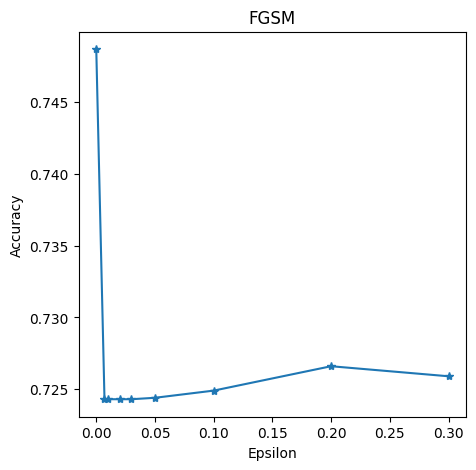

In [8]:
# test_transform = transforms.Compose([transforms.ToTensor()])
# test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

defense(test_loader)